# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
sep="============================================="

recipes = pd.read_csv('recipe_site_traffic_2212.csv', index_col=0)
display(recipes.head())
print(sep)
print(recipes.isna().sum())

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64


# Data Validation

First, we will start by analysing, column by column, the data we have. Confirming that all the data matches the specified type and dealing with missing values.

* **recipe**: The unique numeric identifier of recipe, it will be used as index for the dataframe and not as data.
* **calories**: The number of calories of the recipe, should be numeric. We have to deal with 52 missing values we found. As it is suspicious that the number of missing values is similar in the first 4 columns, we will proceed with the analysis of all of them before making decisions.

In [4]:
print(recipes['calories'].info())

<class 'pandas.core.series.Series'>
Int64Index: 947 entries, 1 to 947
Series name: calories
Non-Null Count  Dtype  
--------------  -----  
895 non-null    float64
dtypes: float64(1)
memory usage: 14.8 KB
None


* **carbohydrate, sugar, protein**: They are all numeric and have also 52 rows of missing data.

In [5]:
cols_missing = ['calories','carbohydrate','sugar','protein']
recipes[cols_missing].isna().sum()

calories        52
carbohydrate    52
sugar           52
protein         52
dtype: int64

Let's inspect if the missing values in these 4 columns are related.

In [6]:
missing_info = recipes[cols_missing].isna().any(axis=1)
missing_info.sum()

52

As we can see, the rows that have missing values for calories, carbohydrates, sugar and protein are the same, i.e. the entries that do not have one have none. By the moment, we will not conclude on how to deal with them, we will be making decissions later when we inspect the rest of the features and the relation between them. By this moment, the most likely decission will be to drop these entries because without this data, we would have a lot of information missing about this recipe.

* **category**: The category of the recipe, has no missing values, but should have been coded as category dtype object and it hasn't. After inspecting, we can find that they are all correct values as described, so we will transform it to category dtype.

In [7]:
print(recipes['category'].unique())
print(sep)
recipes['category'] = recipes['category'].astype('category')
print(recipes['category'].info())

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
<class 'pandas.core.series.Series'>
Int64Index: 947 entries, 1 to 947
Series name: category
Non-Null Count  Dtype   
--------------  -----   
947 non-null    category
dtypes: category(1)
memory usage: 8.7 KB
None


* **servings**: Number of servings for the recipe. It should be int column but has been loaded as object, so let's inspect why.

In [8]:
recipes['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

As we can see, there are 2 "categories" that are non-numeric because it includes the information "as a snack", but:

In [9]:
display(recipes[recipes['servings']=='4 as a snack'])
display(recipes[recipes['servings']=='6 as a snack'])

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High


As we can see, this information is already reflected in the category column of these entries, so we could simply remove this "as a snack" part of the field and keep only the number of servings in the recipe.

In [10]:
recipes['servings'] = (recipes['servings'].str.replace(' as a snack','')).astype('int')
recipes['servings'].info()

<class 'pandas.core.series.Series'>
Int64Index: 947 entries, 1 to 947
Series name: servings
Non-Null Count  Dtype
--------------  -----
947 non-null    int32
dtypes: int32(1)
memory usage: 11.1 KB


* **high_traffic**: Finally the feature that will be the target variable of our problem. As we can find in the details of the data, and we can see in the actual data, this entry was marked with "High" only when the traffic was high after the recipe was shown. The "Low" mark on this feature corresponds to the NaN values of the feature, so let's fix this and convert it into a categorical feature. Let's change also the name of the feature to adapt it to the new information it contains

In [11]:
recipes['traffic'] = recipes['high_traffic'].fillna('Low').astype('category')
recipes.drop('high_traffic', axis=1, inplace=True)

recipes['traffic'].describe()

count      947
unique       2
top       High
freq       574
Name: traffic, dtype: object

In [12]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   category      947 non-null    category
 5   servings      947 non-null    int32   
 6   traffic       947 non-null    category
dtypes: category(2), float64(4), int32(1)
memory usage: 43.0 KB


# Exploratory Analysis

Afer inspecting the different features independently, we'll have a look on the relations between them to get some help taking some decissions, for example, what to do with the missing values.

On the first place, we will be looking at the correlation between different features.

In [13]:
recipes.corr(numeric_only=True)

,calories,carbohydrate,sugar,protein,servings
calories,1.000000,-0.028970,-0.097302,0.172477,-0.034756
carbohydrate,-0.028970,1.000000,0.073922,-0.042795,-0.017895
sugar,-0.097302,0.073922,1.000000,-0.099053,-0.008617
protein,0.172477,-0.042795,-0.099053,1.000000,-0.017926
servings,-0.034756,-0.017895,-0.008617,-0.017926,1.000000


In [14]:
recipes.pivot_table(values='calories', index='category', aggfunc='count')

,calories
category,
Beverages,92
Breakfast,106
Chicken,69
Chicken Breast,94
Dessert,77
Lunch/Snacks,82
Meat,74
One Dish Meal,67
Pork,73


As we can see, there is no correlation between the different features, so we shouldn't delete any of these.

We can also see that the missing values in calories doesn't seem to below to any specific category.

After this analysis and before continuing, I consider that the best option, given the lack of nutritional information in the rows with missing values and that the number of rows with missing values is not very high, in order to try to introduce as little noise as possible, the entries with these missing values will be deleted.

In [15]:
recipes = recipes.dropna(subset=cols_missing)

recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 2 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   category      895 non-null    category
 5   servings      895 non-null    int32   
 6   traffic       895 non-null    category
dtypes: category(2), float64(4), int32(1)
memory usage: 40.7 KB


## Distribution of features
After taking this decission, we will have a look on the distribution of the different features.

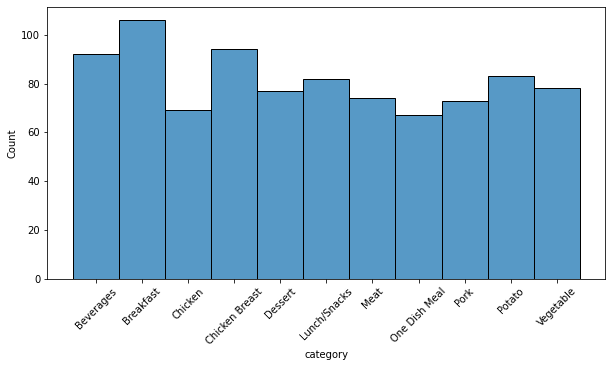

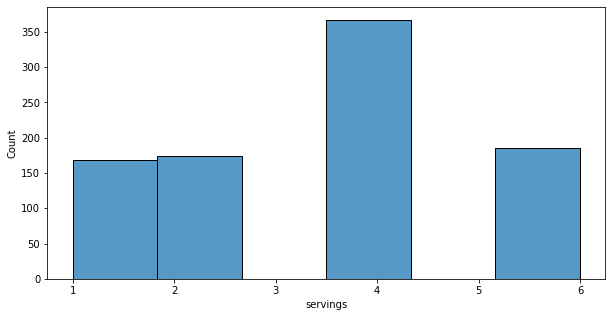

In [16]:
fig,ax = plt.subplots(figsize=(10,5))

sns.histplot(data=recipes, x='category', ax=ax)
plt.xticks(rotation=45)

fig,ax = plt.subplots(figsize=(10,5))

sns.histplot(data=recipes, x='servings', ax=ax, bins=6)
plt.show()

As we can see, the distribution of categories is homogeneous, and about the servings, even though we have no 3 or 5 serving sizes, and 4 servings are more abundant, the count on other servings is also appropiate. 

Let's inspect now the nutritional values features.

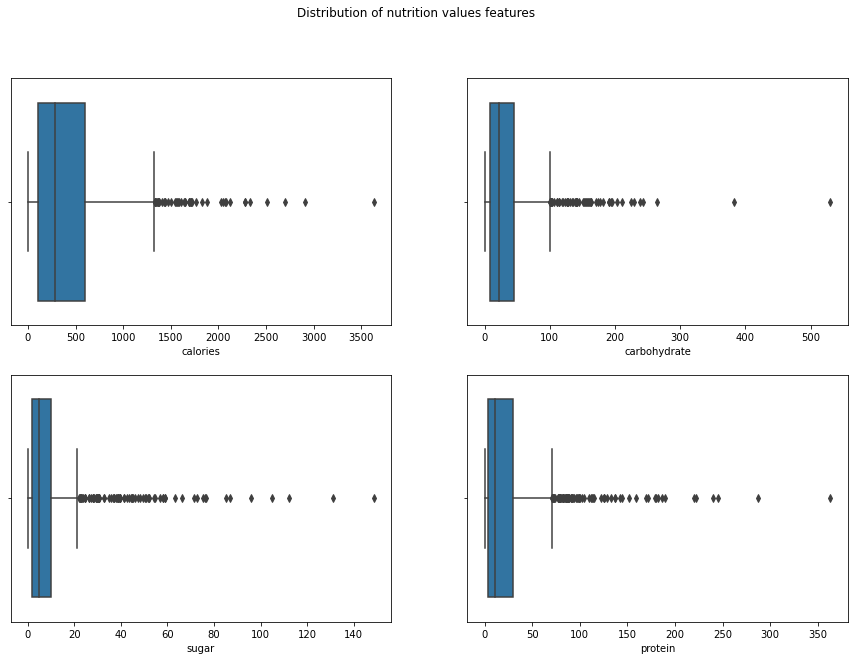

In [17]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Distribution of nutrition values features")

sns.boxplot(data=recipes, x='calories', ax=ax[0,0])
sns.boxplot(data=recipes, x='carbohydrate', ax=ax[0,1])
sns.boxplot(data=recipes, x='sugar', ax=ax[1,0])
sns.boxplot(data=recipes, x='protein', ax=ax[1,1])
plt.show()

As we can see, there are a some outliers in these variables, let's count them.

In [18]:
Q1, Q3 = recipes[cols_missing].quantile(0.25), recipes[cols_missing].quantile(0.75)
IQR = Q3-Q1

outliers = ((recipes[cols_missing]<(Q1-1.5*IQR))|(recipes[cols_missing]>(Q3+1.5*IQR)))

print(outliers.sum())

calories        47
carbohydrate    58
sugar           79
protein         77
dtype: int64


In [19]:
print(outliers.all(axis=1).sum())

0


Even though there are a lot of outliers on the nutritional values features, there are no outliers present in all features at the same time.

Finally, the decision regarding outliers is to do nothing with them

## Target variable dependence
Let's have a look now on the target variable and how it depends on other features by showing some graphics.

In first place, let's represent the distribution of High and not high (low) traffic depending on the category of the recipe.

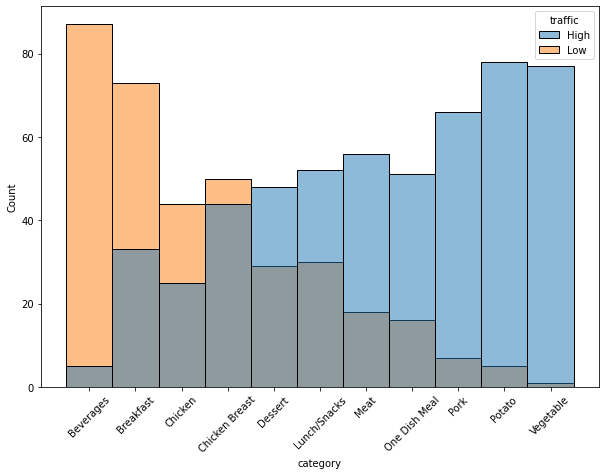

In [20]:
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(data=recipes, x='category', hue='traffic', ax=ax)
plt.xticks(rotation=45)
plt.show()

As we can see, there is a significant influence of the recipe category on how traffic increases.

On the one hand, categories such as Beverages, Breakfast or Chicken do not increase traffic, while others such as Vegetable, Potato or Pork do.

Let's now inspect how the calories of the recipe affect the traffic.

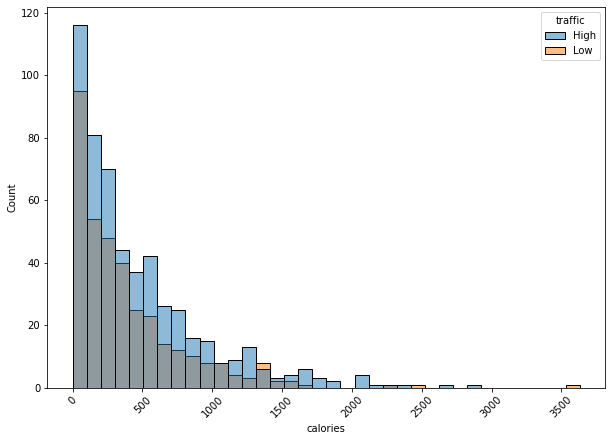

In [21]:
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(data=recipes, x='calories', hue='traffic', ax=ax)
plt.xticks(rotation=45)
plt.show()

As we can see, with respect to the calories, there is not such a clear dependence on the traffic they generate, as this is similar in all calorie ranges.

## Conclusions

We can therefore draw the following conclusions:
* The fact that a recipe produces an increase in traffic will depend greatly on its category and not so much on the calories or ingredients it contains.
* As for the characteristics of nutritional values, we find a skewed distribution, with many outliers, but we are not going to deal with these as they do not represent a large percentage.

# Model Development

## Problem description

First, I would like to introduce the problem.

With the development of this model we would like to get a model that, given the features of a recipe, predicts if this would cause an impact on the traffic on the website or not.

The Product Manager has requested that the model predicts HIGH TRAFFIC RECIPES 80% of the time, this is, we would like to have an 80% of recall (the portion of true positives correctly classified)

## Baseline model

As we have found from analysing the dataset that the category of the recipe is quite a determining factor in whether it will produce an increase in traffic or not, I will implement a model, which, given a dataset, separates the entries by categories and counts, for each one, whether it has produced a majority increase or not.

In terms of prediction, it will remember the data it saw in the training and predict the majority class for the category of each element.

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DummyCategoryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.predictions = {}
    def fit(self, X, y=None):
        categories = np.unique(X[:,4])
        for cat in categories:
            cat_traffic = y[X[:,4]==cat]
            if cat_traffic.sum()>cat_traffic.shape[0]/2:
                self.predictions[cat] = 1
            else:
                self.predictions[cat]=0
        
    def predict(self, X, y=None):
        y_pred = []
        for row in X:
            y_pred.append(self.predictions[row[4]])
        return np.array(y_pred)

## Dataset split
Once we are ready to train our model, the first step is to split the dataset into train and test splits.

In [23]:
X = recipes.drop('traffic', axis=1).values
y = recipes['traffic'].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

X_train.shape, y_train.shape

((716, 6), (716,))

## Preprocessing
After splitting the train and test sets, we need to preprocess the data.

The first step is to convert the categorical variables. For the category, we are using a LabelEncoder, as well as for the target variable.

In [24]:
from sklearn.preprocessing import LabelEncoder

category_encoder = LabelEncoder().fit(X_train[:,4])

X_train[:,4] = category_encoder.transform(X_train[:,4])

target_encoder = LabelEncoder().fit(y_train)

y_train = target_encoder.transform(y_train)

In addition to the encoding, we are going to rescale the numeric variables using an standard scaler.

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[:,[0,1,2,3,5]])

X_train[:,[0,1,2,3,5]] = scaler.transform(X_train[:,[0,1,2,3,5]])

## Train and evaluation

Once we have our data preprocessed and our model created we are going to train it, and to get some results, using cross validation.

In [26]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(DummyCategoryClassifier(), X_train, y_train, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

print(results)
print(sep)
print("Average accuracy: ", results.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[0.77083333 0.76923077 0.72027972 0.75524476 0.79020979]
Average accuracy:  0.7611596736596736


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


As the Product Manager was so interesed about recall, let's repeat the process with recall metric.

In [27]:
results = cross_val_score(DummyCategoryClassifier(), X_train, y_train, scoring='recall', cv=5, verbose=2, n_jobs=-1)

print(results)
print(sep)
print("Average recall: ", results.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[0.67241379 0.70175439 0.66666667 0.68421053 0.84482759]
Average recall:  0.7139745916515426


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


As we can see, this dummy model that only takes into account the category of the recipe has very good results on predicting if the recipe will increase the traffic or not. Let's now create a more complex model.

## More complex Model
Now, we are using a Logistic Regression model, a simple model that may get to classify correctly this dataset.

In [28]:
from sklearn.linear_model import LogisticRegression

results = cross_val_score(LogisticRegression(), X_train, y_train, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

print(results)
print(sep)
print("Average accuracy: ", results.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[0.78472222 0.74825175 0.72727273 0.72027972 0.79020979]
Average accuracy:  0.7541472416472417


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [29]:
results = cross_val_score(LogisticRegression(), X_train, y_train, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

print(results)
print(sep)
print("Average recall: ", results.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[0.78472222 0.74825175 0.72727273 0.72027972 0.79020979]
Average recall:  0.7541472416472417


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Now, as we would like to improve the recall, we could try to change the class_weight parameter to try to give more importance to the positive class, that we would like to predict correctly in an 80% of the cases.

To analyse this we would plot a graphic where we see how the precision and recall vary depending on this parameter.

In [30]:
high_class_weights = list(np.linspace(0.1,1,9))
recalls = []
precisions = []
accuracies = []

for weight in high_class_weights:
    results = cross_val_score(LogisticRegression(class_weight={0:1-weight, 1:weight}), X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    accuracies.append(results.mean())
    results = cross_val_score(LogisticRegression(class_weight={0:1-weight, 1:weight}), X_train, y_train, scoring='recall', cv=5, n_jobs=-1)
    recalls.append(results.mean())
    results = cross_val_score(LogisticRegression(class_weight={0:1-weight, 1:weight}), X_train, y_train, scoring='precision', cv=5, n_jobs=-1)
    precisions.append(results.mean())

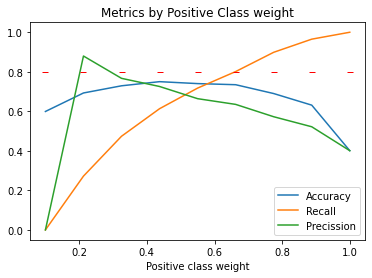

In [31]:
plt.title("Metrics by Positive Class weight")
plt.plot(high_class_weights, accuracies, label='Accuracy')
plt.plot(high_class_weights, recalls, label='Recall')
plt.plot(high_class_weights, precisions, label='Precission')
plt.plot(high_class_weights, [0.8]*len(high_class_weights), 'r_')
plt.xlabel("Positive class weight")
plt.legend()
plt.show()

As can be seen, there is a tradeoff between recall and precision, as is logical.

The more importance is given to the positive class, the higher the recall will increase while the precision (and accuracy at some point) will decrease.

We are now faced with two possibilities:
* To have a balanced model, which predicts with equal accuracy the positive and the negative class.
* To have a model that risks more for the positive class, i.e. that predicts it in a greater number of cases, even though this means a worsening of the overall performance of the model.

Given the stated requirements and the emphasis on the importance of predicting the recipes that will lead to an increase in traffic in 80% of the cases, the second option seems the most logical.

## Even more complex model
To be sure that our model is not underfitting the data, let's try a more complex model, such as Random Forest Classifier

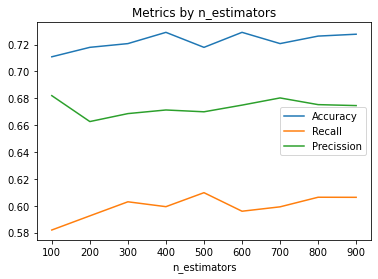

In [34]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = list(range(100, 1000, 100))
recalls = []
precisions = []
accuracies = []

for n in n_estimators:
    results = cross_val_score(RandomForestClassifier(n_estimators=n), X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    accuracies.append(results.mean())
    results = cross_val_score(RandomForestClassifier(n_estimators=n), X_train, y_train, scoring='recall', cv=5, n_jobs=-1)
    recalls.append(results.mean())
    results = cross_val_score(RandomForestClassifier(n_estimators=n), X_train, y_train, scoring='precision', cv=5, n_jobs=-1)
    precisions.append(results.mean())

plt.title("Metrics by n_estimators")
plt.plot(n_estimators, accuracies, label='Accuracy')
plt.plot(n_estimators, recalls, label='Recall')
plt.plot(n_estimators, precisions, label='Precission')
plt.xlabel("n_estimators")
plt.legend()
plt.show()    

As can be seen, an increase on model complexity doesn't lead to better results. That's why we can conclude that Logistic Regression model is not limited by it's complexity.

# Model Evaluation

Let's evaluate the 2 models in the test set, but before we need to apply the same preprocessing.

In [502]:
X_test[:,4] = category_encoder.transform(X_test[:,4])
y_test = target_encoder.transform(y_test)
X_test[:,[0,1,2,3,5]] = scaler.transform(X_test[:,[0,1,2,3,5]])

In [543]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

DCC = DummyCategoryClassifier()
DCC.fit(X_train, y_train)

LR = LogisticRegression(class_weight={0:0.25,1:0.75})
LR.fit(X_train, y_train)

print("DCC Accuracy on test: ", accuracy_score(y_test, DCC.predict(X_test)))
print("DCC Recall on test: ", recall_score(y_test, DCC.predict(X_test)))
print("DCC Precision on test: ", precision_score(y_test, DCC.predict(X_test)))
print(sep)
print("LR Accuracy on test: ", accuracy_score(y_test, LR.predict(X_test)))
print("LR Recall on test: ", recall_score(y_test, LR.predict(X_test)))
print("LR Precision on test: ", precision_score(y_test, LR.predict(X_test)))

DCC Accuracy on test:  0.7653631284916201
DCC Recall on test:  0.6712328767123288
DCC Precision on test:  0.7313432835820896
LR Accuracy on test:  0.7262569832402235
LR Recall on test:  0.821917808219178
LR Precision on test:  0.625


The test set shows the same results that we discovered with the validation set. If we want to improve the recall (to predict correctly more positive recipes), we need to sacrifice a little bit the general accuracy.

# Business Metrics
Let's now translate these results into business metrics.

**What does it mean that we have managed to increase recall to 82%?**

It means that, of the total number of recipes that would drive traffic to the website, our model correctly predicts 82% of them.

**Now, what does it mean that the accuracy is 62.5%?**

It means that, of all the films that our model classifies as candidates to increase traffic to our website, only 62.5% of them will actually do so.


# Final Summary

The project resulted in the creation of a Linear Regression model, which, after adjusting the weight of the positive class to 0.75 and the negative class to 0.25, achieved a recall of 0.82. However, this improvement in recall came at the cost of a reduced precision of 62.5%.

It is essential to acknowledge that this result may not be considered satisfactory, and several factors could be contributing to this outcome:
* **Limited Data Quantity**: The dataset used for this project (even more with the reduction after dropping missing values) might be relatively small, which can hinder the ability of machine learning models to generalize effectively. A larger dataset could potentially lead to more robust model performance
*  **Insufficient or Uninteresting Features**: The features used in the model may not capture the essential aspects that drive increased web traffic effectively. Exploring additional or more informative features, such as preparation time, ingredient quantities, or ingredient costs, already included in the recipes, could provide better insights and improve model performance.

In conclusion, while the current model has achieved a high recall rate, it is essential to address the limitations mentioned above to improve overall model performance. With more data, better features, and potentially more complex models, it is possible to enhance the accuracy and precision of the model, thereby making it more effective in predicting which recipes drive increased web traffic. Future iterations of this project should focus on these areas to achieve more robust and reliable results.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation